# Introduction

This notebook contains my implementation of the [Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784) paper. I start off by going through the theory and then implementing the main ideas of the paper, as best as I can within my resource constrained environment.

# Theory

**Contributions**

The main contributions of this paper are as follows:

1. Introduction of the Conditional GAN.
2. Application of the Conditional GAN to multi-modal learning.

**Significance**

This paper shows that the generative output of the GAN can be conditioned towards a particular mode - such as class labels, or data for inpainting.

**Synxtax**

*   z is a latent variable which is sampled from a fixed prior distribution $p_z(z)$.
*   G is the generative model with trainable parameters $\theta \in \mathbb{R}^{n}$.
*   D is the disciminative model with trainable parameters $\phi \in \mathbb{R}^{m}$.
*   $p_{data}$ is the data distribution.
*   $p_g$ is the generative distribution.
*   $p_{g \cup data} = \{x | x \sim p_{data} \text{or} x \sim p_{g} \}$.
*   $y \in \mathbb{R}^{q}$ is the conditional data.

**Main ideas**

GANs can be extended to a conditional model if both the generator and disciminator are conditioned on some extra information.

**In Equations**

The value function of the GAN with extra information y, becomes:

$$
min_{G} max_{D} V(G, D) = \mathbb{E}_{x \sim p_{data}(x)}[log(D(x|y))] + \mathbb{E}_{z \sim p_{z}(z)}[log(1 - D(G(z|y)))]
$$

This is can be seen as the mappings changing to:

$$
  G: p_{z} × \mathbb{R}^{q} × \mathbb{R}^{n} → p_{g}(\cdot | y)
$$
$$
  G: z × y × \theta \mapsto x
$$

This is the same for the Disciminator:

$$
  D: p_{g \cup data} \times \mathbb{R}^{q} \times \mathbb{R}^{m} → [0, 1]
$$
$$
  D: x \times y \times \phi \mapsto p
$$

It is important the note that we condition the Generator and Discriminator functions, not the distributions we map from.

The author shows this in a simple figure:

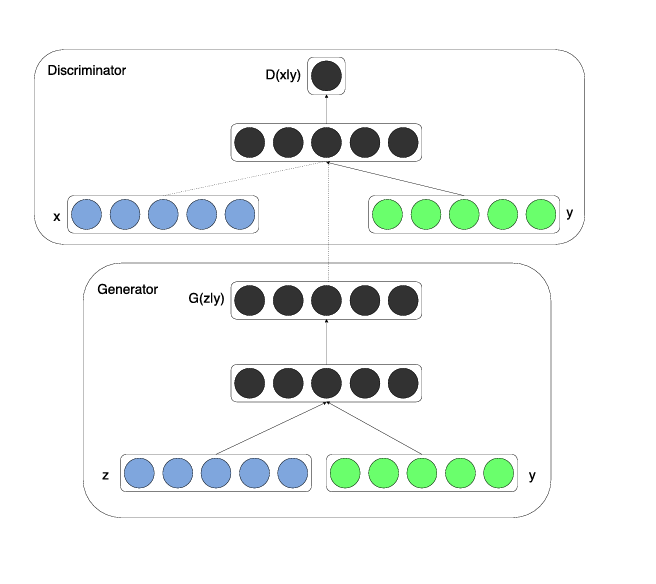

# Implementation

**Disclamer**

I will only apply this architecture to the unimodal setting. The paper contains an application to a multi-modal setting.

## Imports and Installations

In [1]:
!pip install clu

In [2]:
# Don't preallocate VRAM
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"

# data loading
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

# deep learning
import jax
import jax.numpy as jnp
import flax
import flax.linen as nn
import optax
from clu import metrics
from functools import partial

# plotting
import matplotlib.pyplot as plt

# timing
from time import perf_counter

# Hyperparameters

In [3]:
tf.random.set_seed(42)

k = 1
batch_size = 64
latent_dim = 100
EPOCHS = 100
lr = 2e-4

weight_init = nn.initializers.normal(0.02)

latent_dist = lambda key, shape, dtype: jax.random.uniform(key, shape, dtype, minval=-1, maxval=1)

# Data Loading

In [4]:
def get_mnist(batch_size, return_sample = True):
  def neg1_1_normalise(data, label):
    return (tf.cast(data, dtype=tf.float32) - 127.5) / 127.5, tf.one_hot(label, 10)

  MNIST = tfds.load("mnist", as_supervised=True)
  train_ds, test_ds = MNIST["train"], MNIST["test"]

  train_ds = train_ds.map(neg1_1_normalise, num_parallel_calls=tf.data.AUTOTUNE).cache().shuffle(1000).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
  test_ds = test_ds.map(neg1_1_normalise, num_parallel_calls=tf.data.AUTOTUNE).cache().batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

  if return_sample == True:
    for sample_data, sample_label in train_ds.as_numpy_iterator():
      print("Sample data:", sample_data.shape)
      print("Sample label:", sample_label.shape)
      plt.figure(figsize=(2,2))
      plt.imshow((sample_data[0]+1)/2)
      return train_ds, test_ds, sample_data, sample_label
  return train_ds, test_ds

Sample data: (64, 28, 28, 1)
Sample label: (64, 10)
tf.Tensor(937, shape=(), dtype=int64)


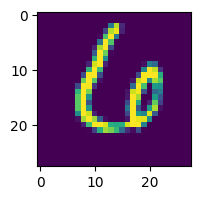

In [5]:
train_ds, test_ds, sample_data, sample_label = get_mnist(batch_size)
print(train_ds.cardinality())

## TrainState and Metrics

In [6]:
from flax.training import train_state

@flax.struct.dataclass
class Metrics(metrics.Collection):
  loss: metrics.Average.from_output("loss")

class TrainState(train_state.TrainState):
  rng: jax.Array
  metrics: Metrics = Metrics.empty()

## Create and Initialise State

In [7]:
def create_state_and_initialise_model(G, D, sample_data, sample_label, latent_dim, random_key):
  keys = jax.random.split(random_key, 4)
  sample_latent = jnp.zeros((batch_size, latent_dim))

  g = G()
  d = D()

  g_vars = g.init(keys[0], sample_latent, sample_label, train=False)
  d_vars = d.init(keys[1], sample_data, sample_label, train=False)

  print(g.tabulate(keys[0], sample_latent, sample_label, train=False))
  print(d.tabulate(keys[1], sample_data, sample_label, train=False))

  g_state = TrainState.create(
      apply_fn=g.apply,
      params=g_vars["params"],
      tx=optax.adam(lr, b1=0.5),
      rng=keys[2]
  )

  d_state = TrainState.create(
      apply_fn=d.apply,
      params=d_vars["params"],
      tx=optax.adam(lr, b1=0.5),
      rng=keys[3]
  )

  return g_state, d_state, g, d

## Model Definition

In [8]:
class G(nn.Module):
  @nn.compact
  def __call__(self, z, y, train):
    z = jnp.concatenate([z, y], axis=-1)

    z = nn.Dense(300, kernel_init=weight_init)(z)
    z = nn.relu(z)
    z = nn.Dropout(0.1, deterministic=not train)(z)

    z = nn.Dense(500, kernel_init=weight_init)(z)
    z = nn.relu(z)
    z = nn.Dropout(0.1, deterministic=not train)(z)

    z = nn.Dense(784, kernel_init=weight_init)(z)
    z = nn.tanh(z)
    z = z.reshape([z.shape[0], 28, 28, 1])
    return z

class D(nn.Module):
  @nn.compact
  def __call__(self, x, y, train):

    x = x.reshape([x.shape[0], -1])

    x = jnp.concatenate([x, y], axis=-1)

    x = nn.Dense(500, kernel_init=weight_init)(x)
    x = nn.relu(x)
    x = nn.Dropout(0.1, deterministic=not train)(x)

    x = nn.Dense(300, kernel_init=weight_init)(x)
    x = nn.relu(x)
    x = nn.Dropout(0.1, deterministic=not train)(x)

    x = nn.Dense(1, kernel_init=weight_init)(x)
    return x

## Disciminator Train Step

In [9]:
@jax.jit
def d_train_step(g_state, d_state, batch):
  data, label = batch
  ones = jnp.ones((batch_size, 1))
  zeros = jnp.zeros((batch_size, 1))
  latent_key, d_dropout_key_1, d_dropout_key_2 = jax.random.split(jax.random.fold_in(d_state.rng, d_state.step), 3)
  z = latent_dist(latent_key, (batch_size, latent_dim), data.dtype)

  def loss(params):
    tru_logits = d_state.apply_fn({"params": params}, data, label, train=True, rngs={"dropout": d_dropout_key_1})
    tru_loss = optax.sigmoid_binary_cross_entropy(logits=tru_logits, labels=ones)

    gen_x = g_state.apply_fn({"params": g_state.params}, z, label, train=False)
    gen_logits = d_state.apply_fn({"params": params}, gen_x, label, train=True, rngs={"dropout": d_dropout_key_2})
    gen_loss = optax.sigmoid_binary_cross_entropy(logits=gen_logits, labels=zeros)

    return (tru_loss + gen_loss).mean() / 2

  grad_fn = jax.value_and_grad(loss)

  d_loss, grads = grad_fn(d_state.params)

  metrics = d_state.metrics.single_from_model_output(loss=d_loss)
  metrics = d_state.metrics.merge(metrics)

  d_state = d_state.apply_gradients(grads=grads, metrics=metrics)
  return d_state

## Generator Train Step

In [10]:
@jax.jit
def g_train_step(g_state, d_state, batch):
  data, label = batch
  ones = jnp.ones((batch_size, 1))
  latent_key, g_dropout_key = jax.random.split(jax.random.fold_in(g_state.rng, g_state.step), 2)
  z = latent_dist(latent_key, (batch_size, latent_dim), data.dtype)
  def loss(params):
    gen_x = g_state.apply_fn({"params": params}, z, label, train=True, rngs={"dropout": g_dropout_key})
    logits = d_state.apply_fn({"params": d_state.params}, gen_x, label, train=False)
    loss = optax.sigmoid_binary_cross_entropy(logits=logits, labels=ones).mean()
    return loss

  grad_fn = jax.value_and_grad(loss)

  g_loss, grads = grad_fn(g_state.params)

  metrics = g_state.metrics.single_from_model_output(loss=g_loss)
  metrics = g_state.metrics.merge(metrics)

  g_state = g_state.apply_gradients(grads=grads, metrics=metrics)
  return g_state

## Helpers

In [11]:
def update_metrics(g_state, d_state, metrics_history):
  for k,v in g_state.metrics.compute().items():
    metrics_history[f"g_train_{k}"].append(v)
  for k,v in d_state.metrics.compute().items():
    metrics_history[f"d_train_{k}"].append(v)
  d_state = d_state.replace(metrics=d_state.metrics.empty())
  g_state = g_state.replace(metrics=g_state.metrics.empty())
  return g_state, d_state, metrics_history

In [12]:
def neg1_1_to_0_1(image):
  return (image + 1.0) / 2.0

def plot_samples(n=None, z=None):
  y = jnp.eye(10, 10)
  if z == None:
    z = latent_dist(jax.random.PRNGKey(453453), shape=(10, latent_dim), dtype=jnp.float32)
  n = len(z)

  gen_x = g_state.apply_fn({"params": g_state.params}, z, y, train=False)
  gen_x = neg1_1_to_0_1(gen_x)

  fig, axs = plt.subplots(nrows=1, ncols=n, figsize=(15, n*15))
  for i in range(n):
    axs[i].imshow(gen_x[i], interpolation="nearest")
  plt.axis("off")
  plt.tight_layout()
  plt.show()

# Training

In [13]:
g_state, d_state, g, d = create_state_and_initialise_model(G, D, sample_data, sample_label, latent_dim, jax.random.PRNGKey(0))


                                         G Summary                                          
┏━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path      ┃ module  ┃ inputs            ┃ outputs             ┃ params                   ┃
┡━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           │ G       │ - float32[64,100] │ float32[64,28,28,1] │                          │
│           │         │ - float32[64,10]  │                     │                          │
│           │         │ - train: False    │                     │                          │
├───────────┼─────────┼───────────────────┼─────────────────────┼──────────────────────────┤
│ Dense_0   │ Dense   │ float32[64,110]   │ float32[64,300]     │ bias: float32[300]       │
│           │         │                   │                     │ kernel: float32[110,300] │
│           │         │                   │                     │    

In [14]:
metrics_history = {
    "g_train_loss": [],
    "d_train_loss": [],
}

In [15]:
i = 0
plt.ion()

for epoch in range(1, EPOCHS + 1):
  start = perf_counter()
  for batch in train_ds.as_numpy_iterator():
    if i < k:
      d_state = d_train_step(g_state, d_state, batch)
      i += 1
    else:
      g_state = g_train_step(g_state, d_state, batch)
      i = 0

  g_state, d_state, metrics_history = update_metrics(g_state, d_state, metrics_history)

  g_loss = metrics_history["g_train_loss"][-1]
  d_loss = metrics_history["d_train_loss"][-1]

  print(f"Epoch {epoch} | d step {d_state.step}, g step {g_state.step} | Time: {perf_counter()-start}s | g loss: {g_loss} | d loss: {d_loss}.")
  plot_samples()

Output hidden; open in https://colab.research.google.com to view.

Epoch 1 | d step 47319, g step 47318 | Time: 5.11988340500011s | g loss: 1.4164577722549438 | d loss: 0.5073889493942261.


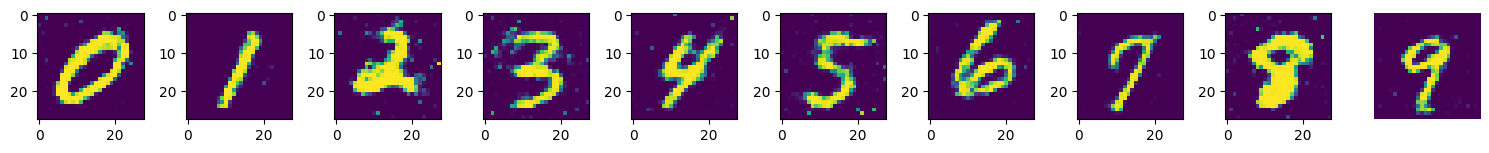

Epoch 2 | d step 47787, g step 47787 | Time: 5.1132191460001195s | g loss: 1.4362223148345947 | d loss: 0.5018565654754639.


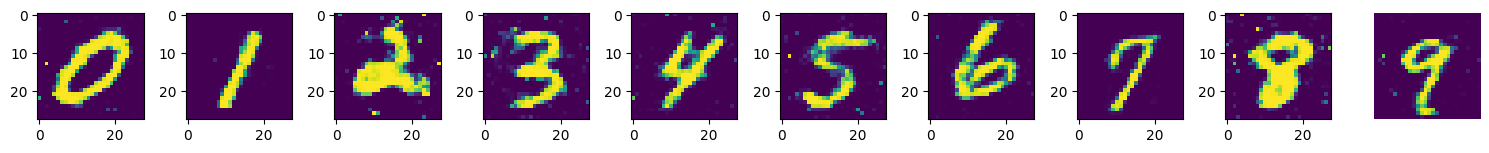

Epoch 3 | d step 48256, g step 48255 | Time: 2.5519198590000087s | g loss: 1.4420870542526245 | d loss: 0.5040226578712463.


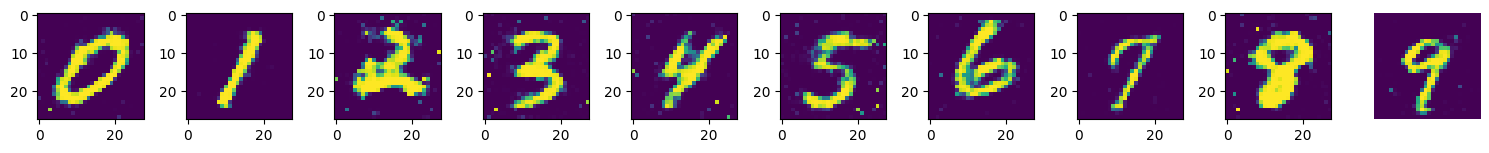

Epoch 4 | d step 48724, g step 48724 | Time: 2.5462026699997296s | g loss: 1.4358956813812256 | d loss: 0.5056700110435486.


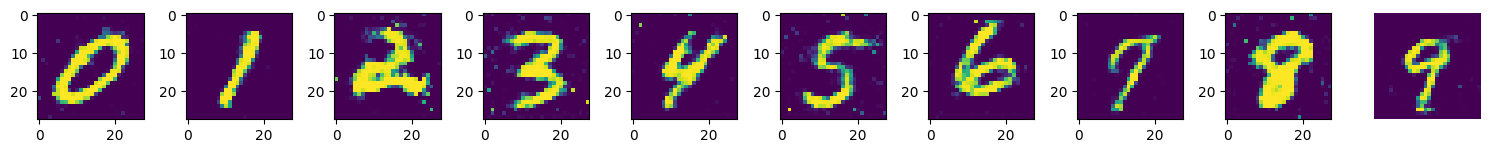

Epoch 5 | d step 49193, g step 49192 | Time: 1.2411382359996423s | g loss: 1.4297561645507812 | d loss: 0.5041152834892273.


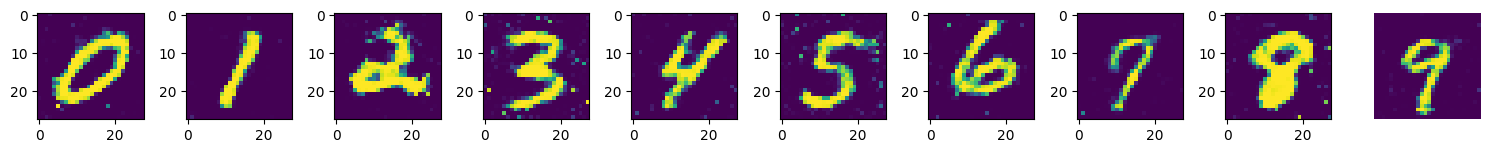

Epoch 6 | d step 49661, g step 49661 | Time: 2.5463502689999586s | g loss: 1.435732126235962 | d loss: 0.5017671585083008.


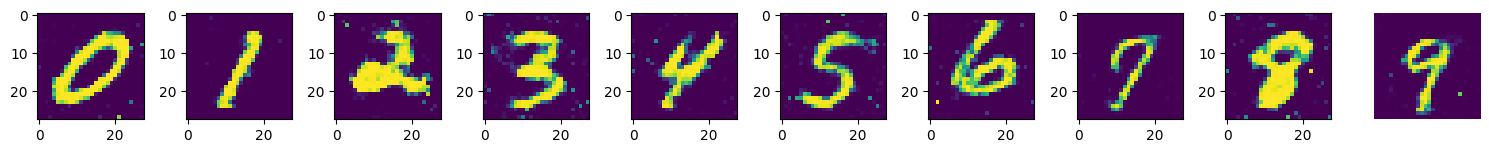

Epoch 7 | d step 50130, g step 50129 | Time: 1.3487605399996028s | g loss: 1.4447749853134155 | d loss: 0.5026648640632629.


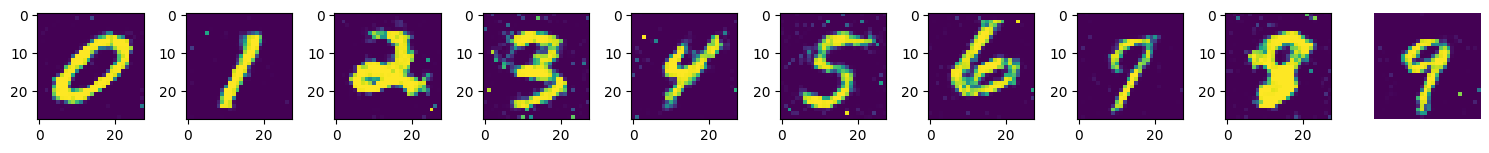

Epoch 8 | d step 50598, g step 50598 | Time: 2.547904903000017s | g loss: 1.4492919445037842 | d loss: 0.5020709037780762.


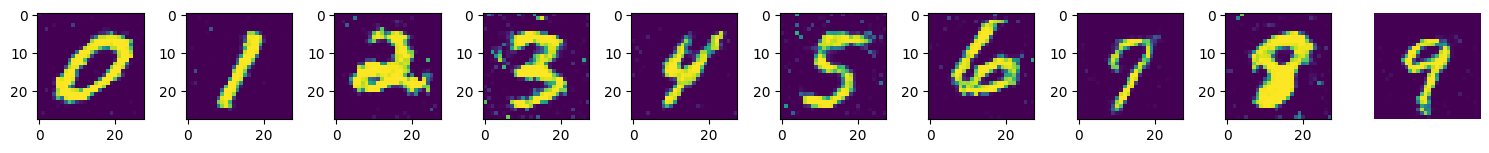

Epoch 9 | d step 51067, g step 51066 | Time: 1.3092316299998856s | g loss: 1.442963719367981 | d loss: 0.5016478896141052.


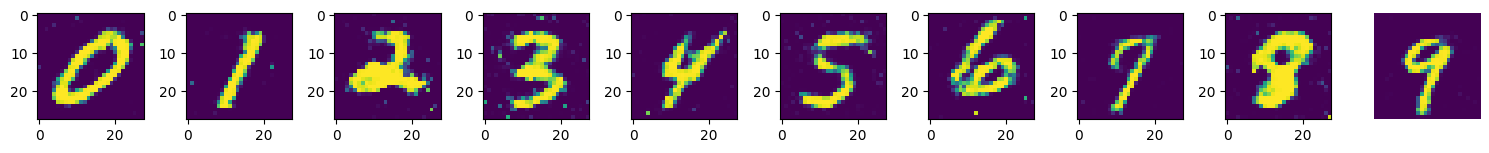

Epoch 10 | d step 51535, g step 51535 | Time: 2.5472815680004715s | g loss: 1.4444454908370972 | d loss: 0.5012009739875793.


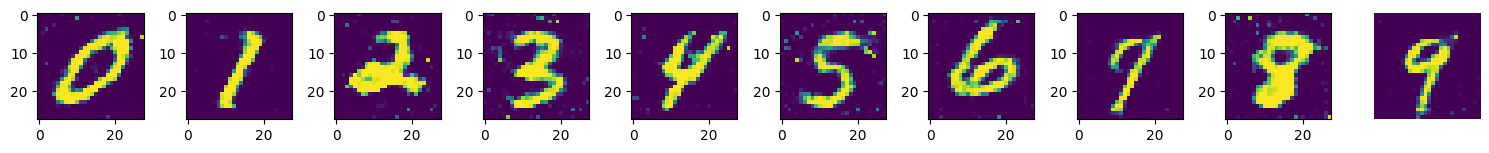

Epoch 11 | d step 52004, g step 52003 | Time: 1.5753297250003016s | g loss: 1.4371347427368164 | d loss: 0.5043044686317444.


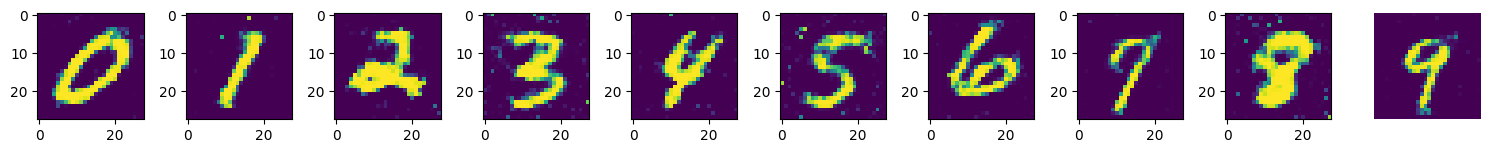

Epoch 12 | d step 52472, g step 52472 | Time: 2.544848272999843s | g loss: 1.4327284097671509 | d loss: 0.5059624314308167.


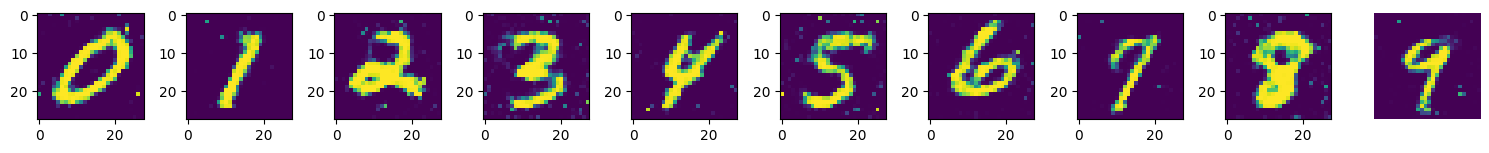

Epoch 13 | d step 52941, g step 52940 | Time: 1.3616785100002744s | g loss: 1.435564637184143 | d loss: 0.5045715570449829.


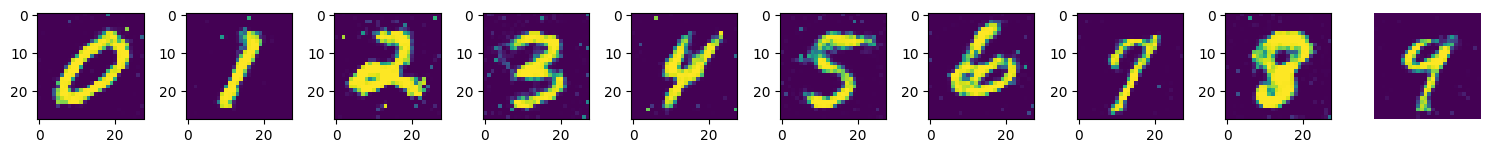

Epoch 14 | d step 53409, g step 53409 | Time: 2.548971898000673s | g loss: 1.4408522844314575 | d loss: 0.5045548677444458.


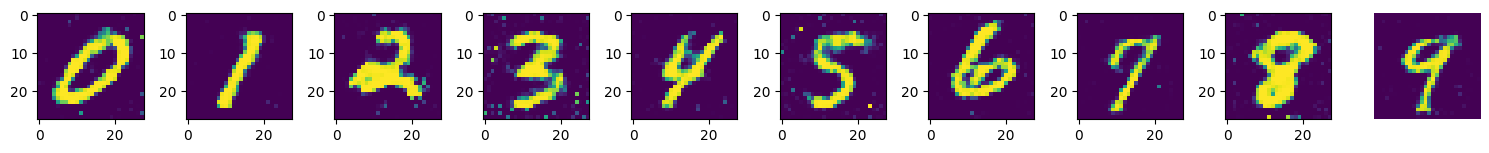

Epoch 15 | d step 53878, g step 53877 | Time: 1.3535488809993694s | g loss: 1.4458363056182861 | d loss: 0.5013922452926636.


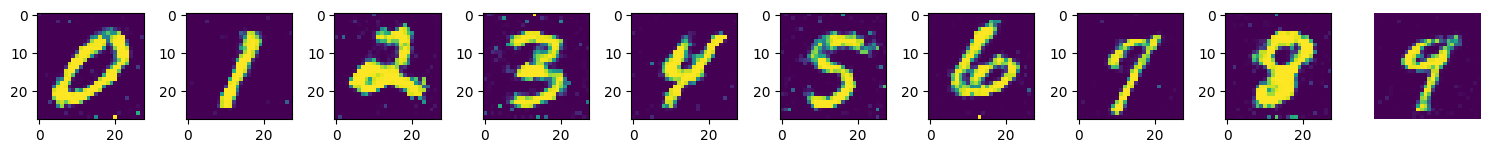

Epoch 16 | d step 54346, g step 54346 | Time: 2.5502977139994982s | g loss: 1.4538325071334839 | d loss: 0.5051220059394836.


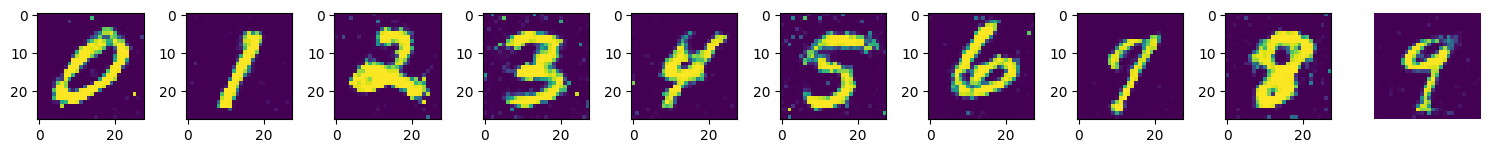

Epoch 17 | d step 54815, g step 54814 | Time: 1.2873284710003645s | g loss: 1.4603556394577026 | d loss: 0.4978598952293396.


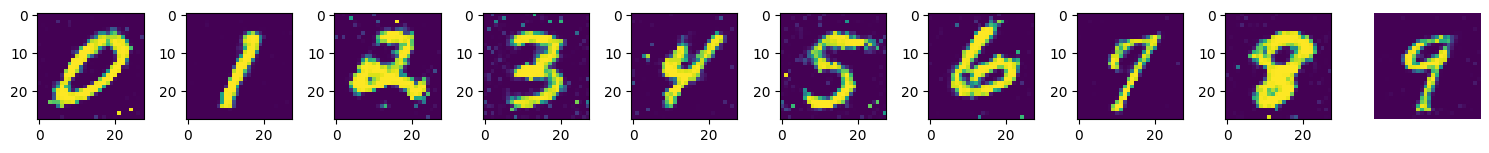

Epoch 18 | d step 55283, g step 55283 | Time: 1.3311623339996004s | g loss: 1.4514344930648804 | d loss: 0.5056525468826294.


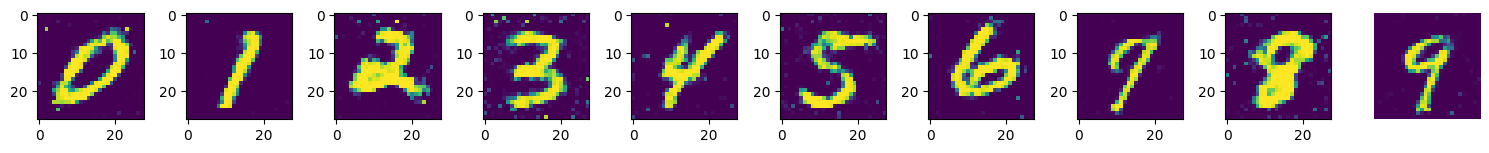

Epoch 19 | d step 55752, g step 55751 | Time: 1.3028155479996713s | g loss: 1.44460928440094 | d loss: 0.5057777762413025.


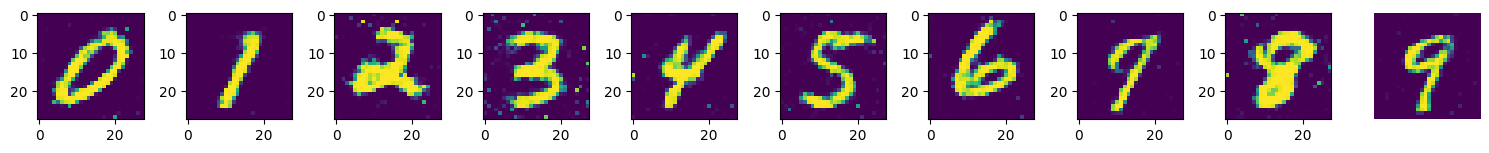

Epoch 20 | d step 56220, g step 56220 | Time: 2.547848566000539s | g loss: 1.4701184034347534 | d loss: 0.49901875853538513.


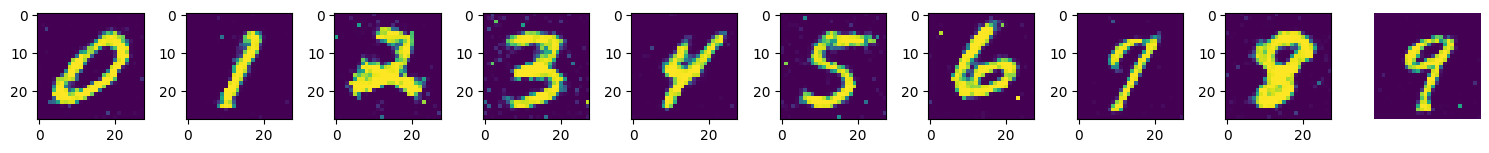

Epoch 21 | d step 56689, g step 56688 | Time: 1.6356553739997253s | g loss: 1.4742543697357178 | d loss: 0.5032364726066589.


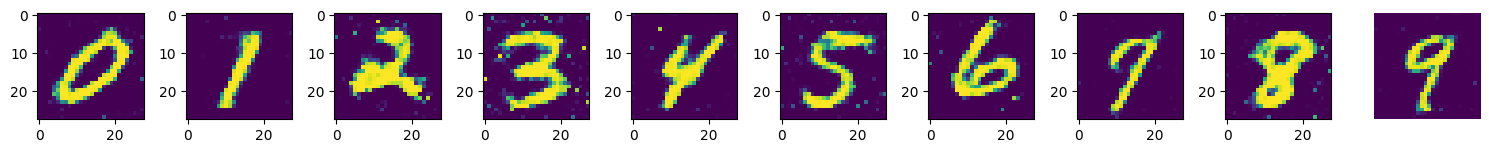

Epoch 22 | d step 57157, g step 57157 | Time: 1.3021465450001415s | g loss: 1.4642924070358276 | d loss: 0.5040645003318787.


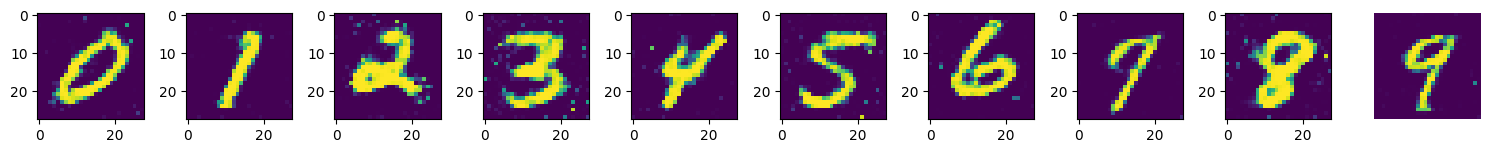

Epoch 23 | d step 57626, g step 57625 | Time: 1.3069081769999684s | g loss: 1.4563599824905396 | d loss: 0.5072594285011292.


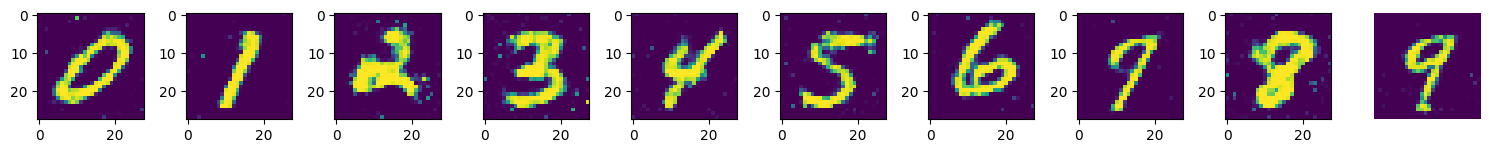

Epoch 24 | d step 58094, g step 58094 | Time: 2.547087478999856s | g loss: 1.4581012725830078 | d loss: 0.5053382515907288.


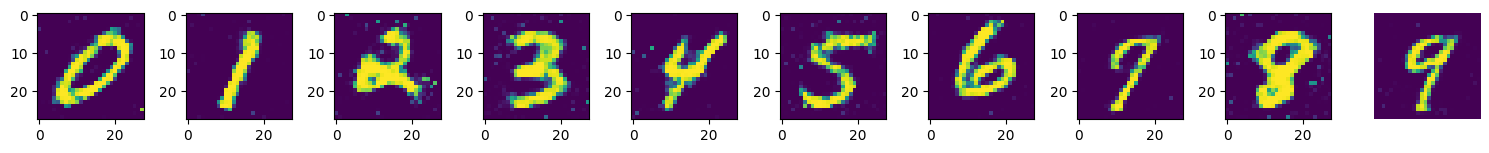

Epoch 25 | d step 58563, g step 58562 | Time: 1.3406946409995726s | g loss: 1.4614702463150024 | d loss: 0.501455545425415.


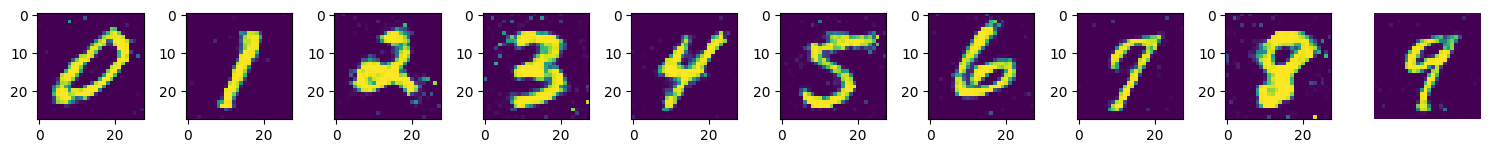

Epoch 26 | d step 59031, g step 59031 | Time: 1.312294046999341s | g loss: 1.4654122591018677 | d loss: 0.5079076290130615.


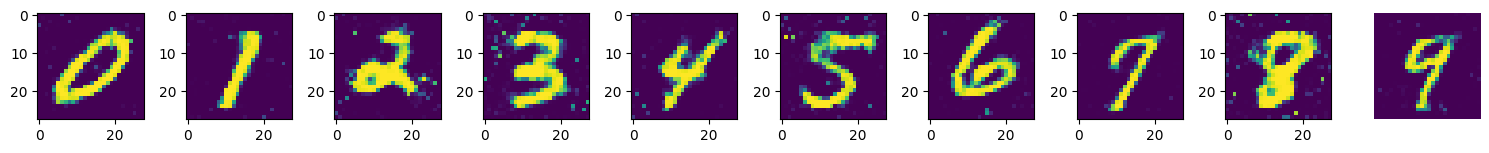

Epoch 27 | d step 59500, g step 59499 | Time: 1.3067180130001361s | g loss: 1.4659937620162964 | d loss: 0.5028266906738281.


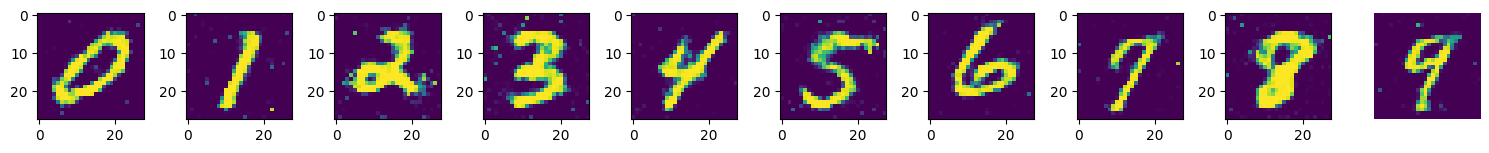

Epoch 28 | d step 59968, g step 59968 | Time: 1.3206932150005741s | g loss: 1.472131609916687 | d loss: 0.5039015412330627.


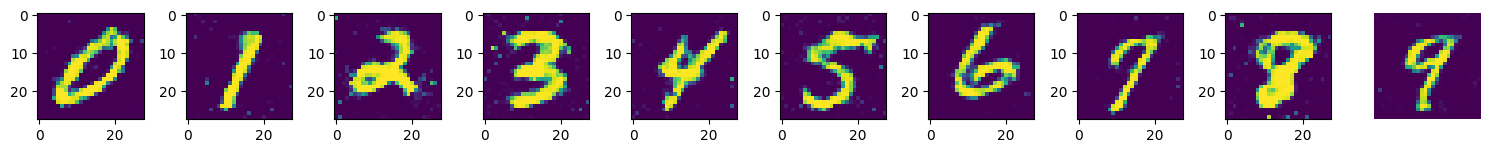

Epoch 29 | d step 60437, g step 60436 | Time: 2.5470105330005026s | g loss: 1.4654319286346436 | d loss: 0.5040255784988403.


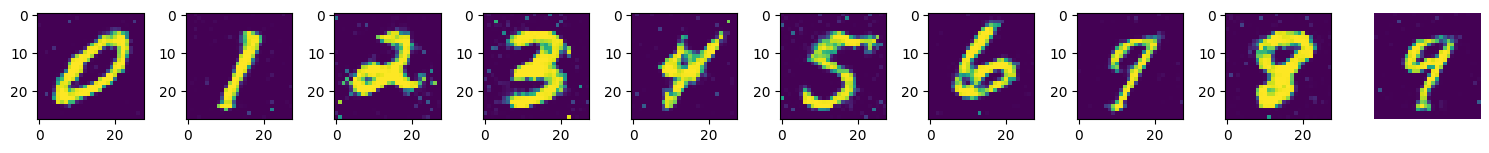

Epoch 30 | d step 60905, g step 60905 | Time: 1.3231943209993915s | g loss: 1.4638599157333374 | d loss: 0.5026155710220337.


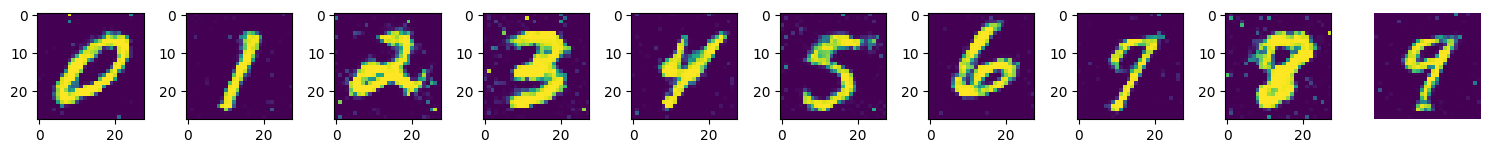

Epoch 31 | d step 61374, g step 61373 | Time: 1.3070283269998981s | g loss: 1.4743547439575195 | d loss: 0.5048893094062805.


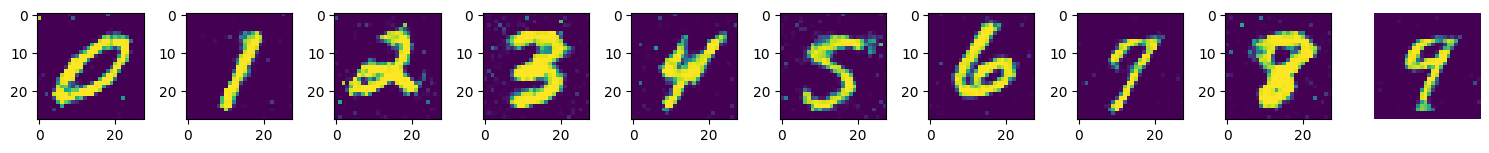

Epoch 32 | d step 61842, g step 61842 | Time: 1.3653134779997345s | g loss: 1.4611866474151611 | d loss: 0.503630518913269.


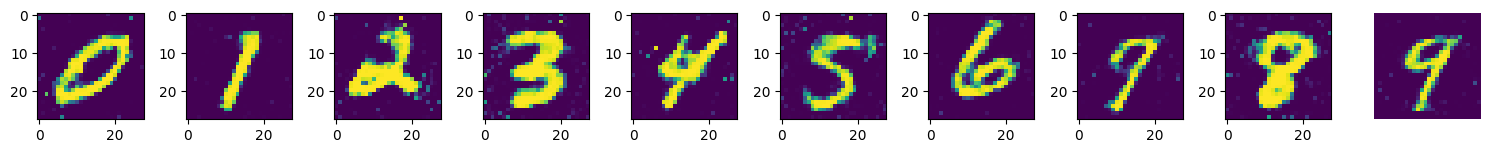

Epoch 33 | d step 62311, g step 62310 | Time: 2.546126643000207s | g loss: 1.46233332157135 | d loss: 0.503265917301178.


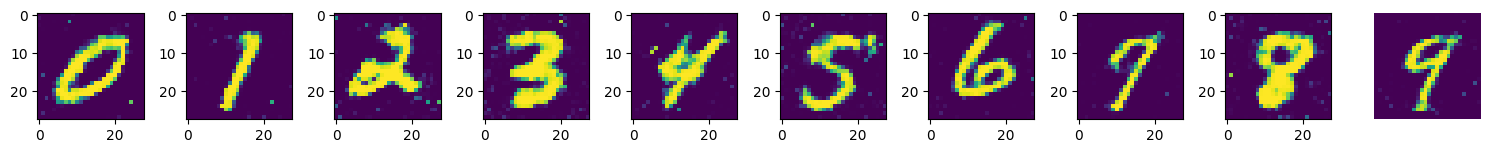

Epoch 34 | d step 62779, g step 62779 | Time: 1.347742050999841s | g loss: 1.4669047594070435 | d loss: 0.5045928359031677.


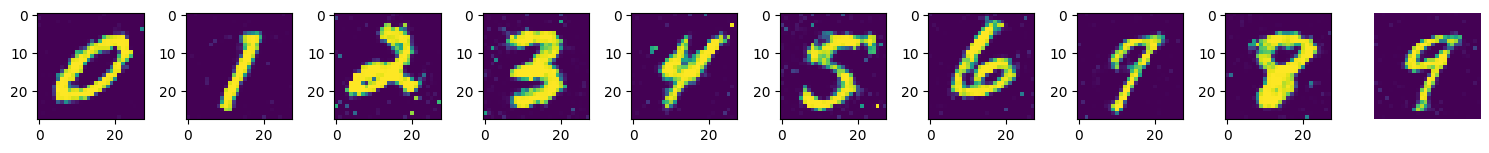

Epoch 35 | d step 63248, g step 63247 | Time: 1.3328586959996755s | g loss: 1.4573262929916382 | d loss: 0.5062075853347778.


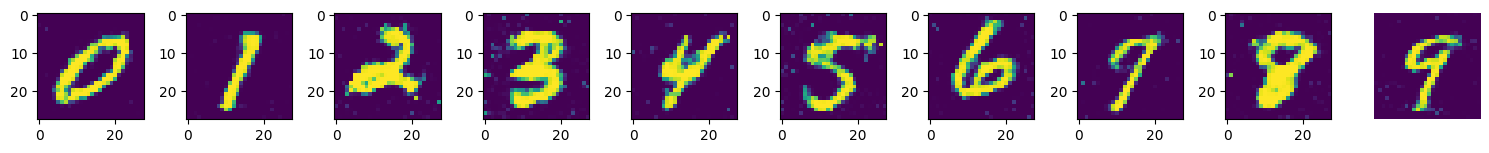

Epoch 36 | d step 63716, g step 63716 | Time: 2.5468640870003583s | g loss: 1.4744141101837158 | d loss: 0.5064381957054138.


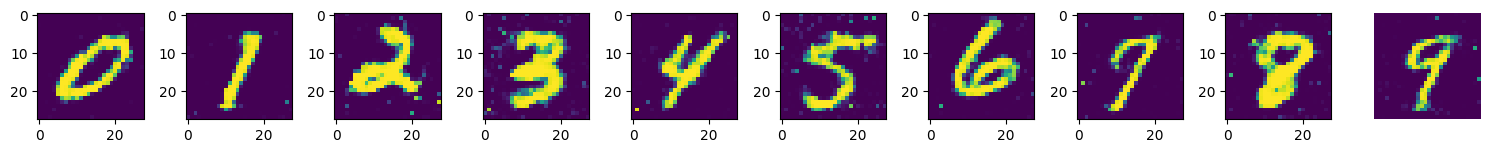

Epoch 37 | d step 64185, g step 64184 | Time: 1.5659585850007716s | g loss: 1.475273609161377 | d loss: 0.5031258463859558.


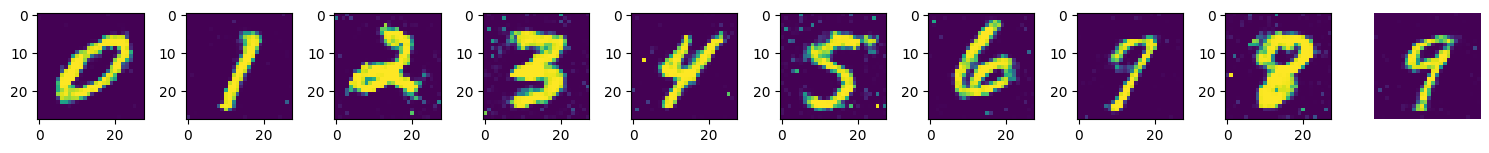

Epoch 38 | d step 64653, g step 64653 | Time: 1.4086886450004386s | g loss: 1.467459797859192 | d loss: 0.5042851567268372.


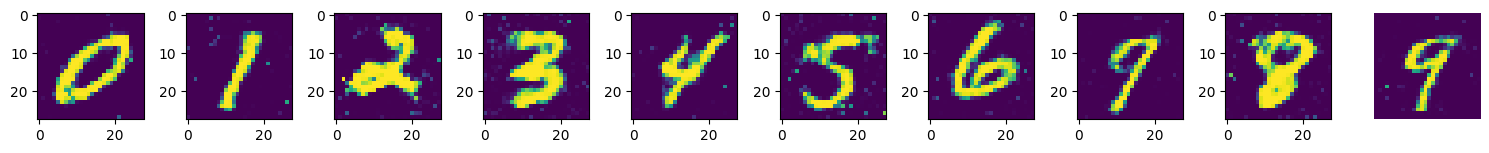

Epoch 39 | d step 65122, g step 65121 | Time: 1.294978469999478s | g loss: 1.4707794189453125 | d loss: 0.5068886280059814.


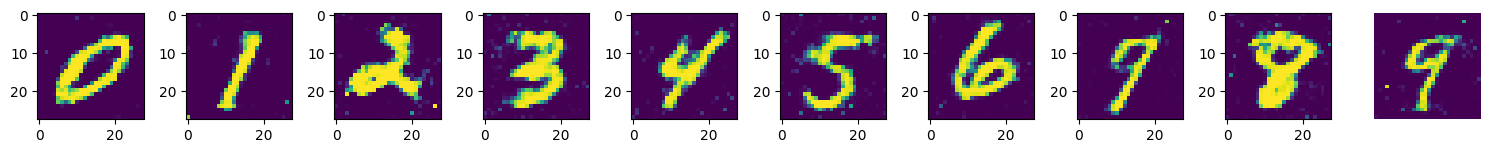

Epoch 40 | d step 65590, g step 65590 | Time: 2.5474715829996057s | g loss: 1.4685075283050537 | d loss: 0.5047991871833801.


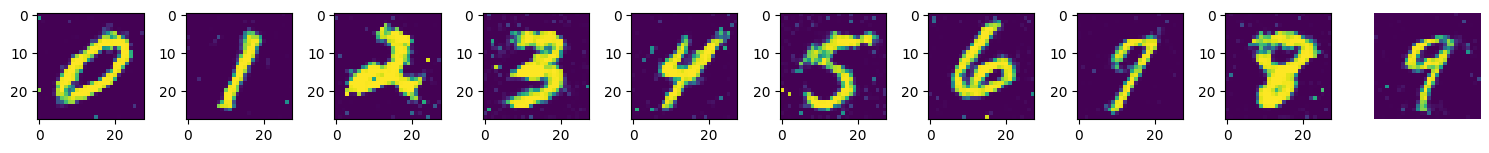

Epoch 41 | d step 66059, g step 66058 | Time: 1.29012114499983s | g loss: 1.4709441661834717 | d loss: 0.5017983913421631.


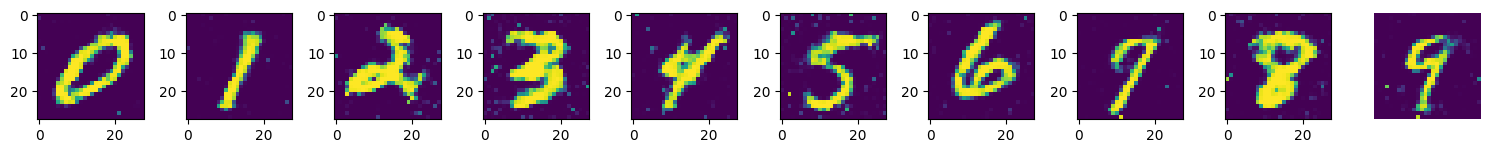

Epoch 42 | d step 66527, g step 66527 | Time: 2.547709911000311s | g loss: 1.4795728921890259 | d loss: 0.5040339827537537.


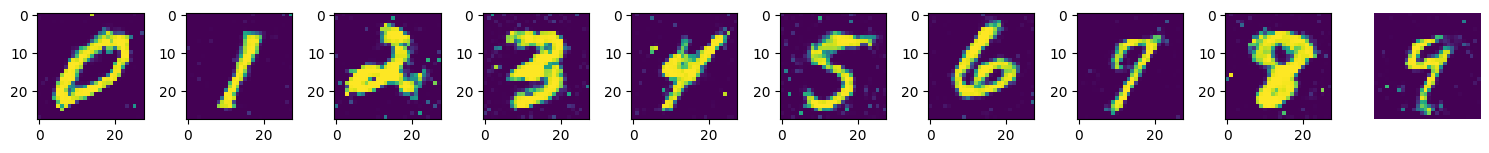

Epoch 43 | d step 66996, g step 66995 | Time: 1.2682052180007304s | g loss: 1.4693609476089478 | d loss: 0.5024009346961975.


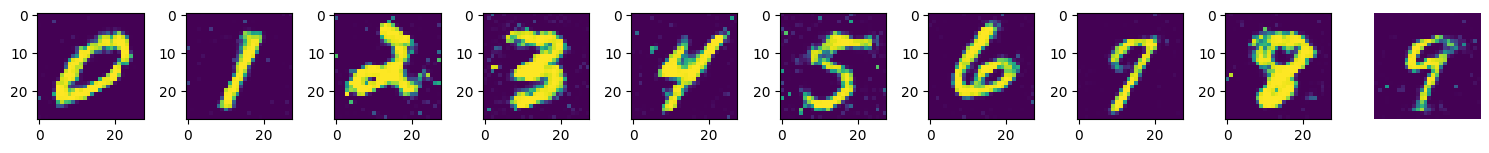

Epoch 44 | d step 67464, g step 67464 | Time: 1.293387124000219s | g loss: 1.467826008796692 | d loss: 0.506708025932312.


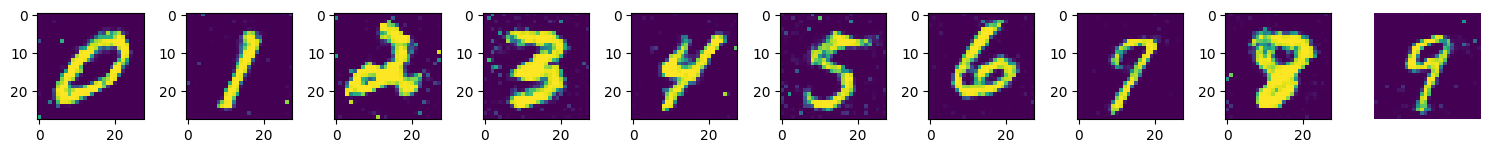

Epoch 45 | d step 67933, g step 67932 | Time: 1.3049704450004356s | g loss: 1.4576393365859985 | d loss: 0.5060616731643677.


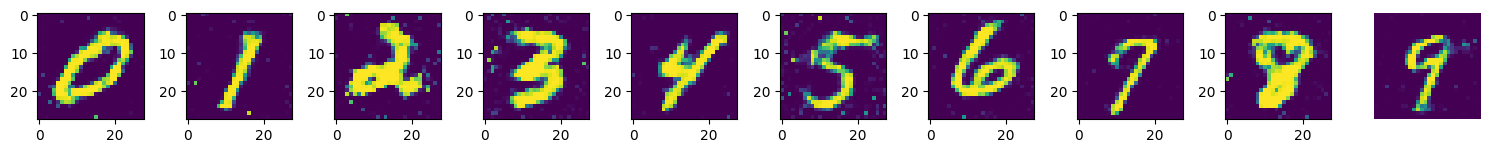

Epoch 46 | d step 68401, g step 68401 | Time: 2.547336266000457s | g loss: 1.4508715867996216 | d loss: 0.501789927482605.


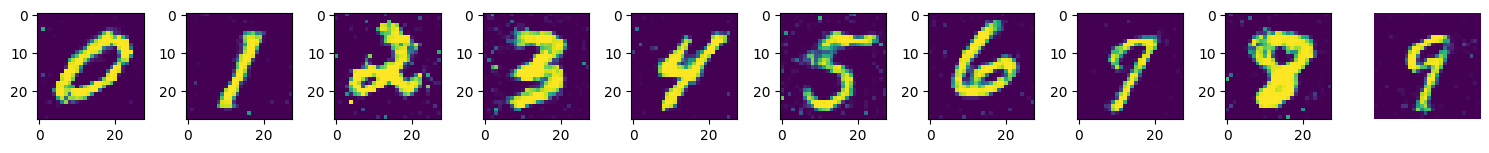

Epoch 47 | d step 68870, g step 68869 | Time: 1.333111906999875s | g loss: 1.477230191230774 | d loss: 0.503777801990509.


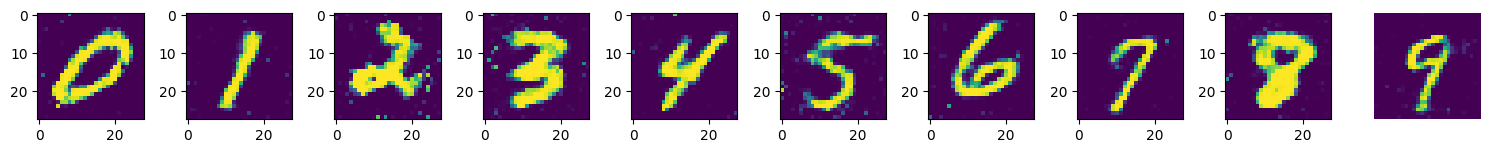

Epoch 48 | d step 69338, g step 69338 | Time: 1.3009776460003195s | g loss: 1.4750584363937378 | d loss: 0.5036513805389404.


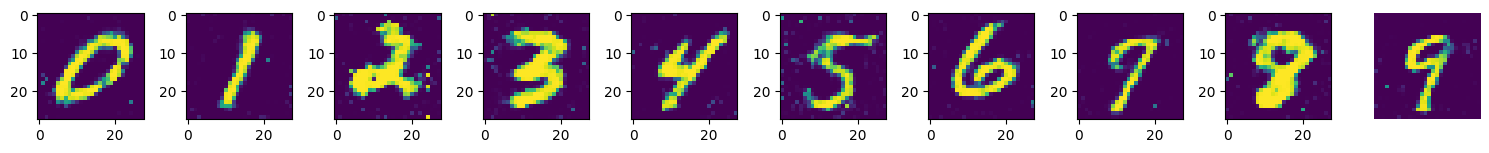

Epoch 49 | d step 69807, g step 69806 | Time: 1.2917294029994082s | g loss: 1.487187147140503 | d loss: 0.49982398748397827.


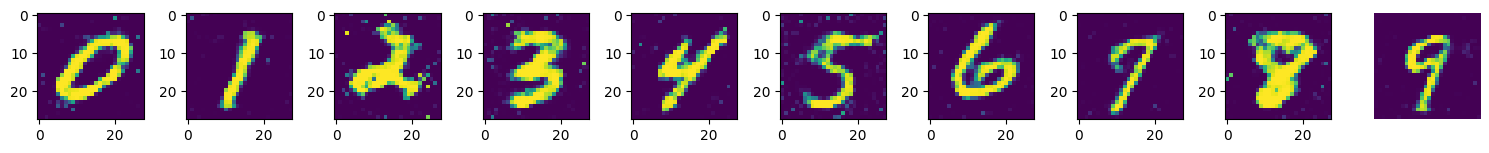

Epoch 50 | d step 70275, g step 70275 | Time: 1.3222287559992765s | g loss: 1.485560417175293 | d loss: 0.5055293440818787.


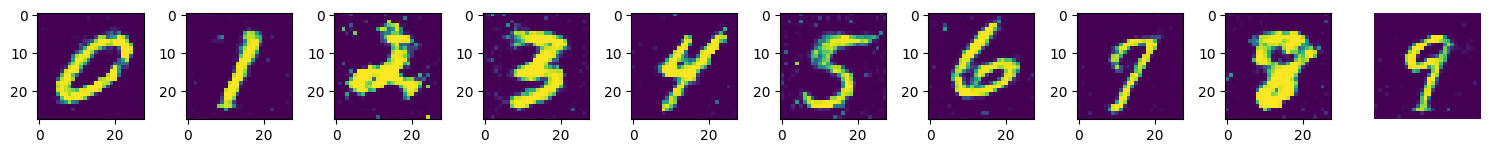

In [16]:
i = 0
plt.ion()

for epoch in range(1, 50 + 1):
  start = perf_counter()
  for batch in train_ds.as_numpy_iterator():
    if i < k:
      d_state = d_train_step(g_state, d_state, batch)
      i += 1
    else:
      g_state = g_train_step(g_state, d_state, batch)
      i = 0

  g_state, d_state, metrics_history = update_metrics(g_state, d_state, metrics_history)

  g_loss = metrics_history["g_train_loss"][-1]
  d_loss = metrics_history["d_train_loss"][-1]

  print(f"Epoch {epoch} | d step {d_state.step}, g step {g_state.step} | Time: {perf_counter()-start}s | g loss: {g_loss} | d loss: {d_loss}.")
  plot_samples()

# Conclusions

CGANs are a method of training a Generative Network via the GAN process but the model is fed extra information. For instance, in the above I used the MNIST labels allowing the Generator to produce samples by label. This is powerful in being able to produce results that contain desirable characteristics. Additionally, notice that training for 150 epochs looks worse than training for 100 epochs. This is a known problem with GANs - overfitting can cause bad results.